<a href="https://colab.research.google.com/github/Nickdv9/CustomerSegmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

We're using a shopping mall customer data taken from [Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python?resource=download) to demonstrate customer segmentation that resembles a newly occupied business scenario.

**Dataset description:**

| CustomerID | Gender | Age | Annual Income (k$) | Spending Score (1-100) |
| ---------- | ------ | --- | ------------------ | ---------------------- |
| Unique ID assigned to the customer | Gender of the customer | Age of the customer | Annual Income of the customer | Score assigned by the mall based on customer behavior and spending nature | 



## Imports

In [41]:
import numpy as np
import pandas as pd
from pandas.core.common import random_state
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
!pip install kneed
from kneed import KneeLocator

## Loading data

In [3]:
data = pd.read_csv('sample_data/Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Exploratory Data Analysis

### Exploring basic features

In [4]:
data.shape

(200, 5)

Getting an overview of available data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Currently the data consists mostly of numerical values

In [6]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Let us also check for columns having categorical values

In [39]:
categorical_cols = data.select_dtypes("object").columns
categorical_cols = list(categorical_cols)
categorical_cols

['Gender']

### Cleaning data

We check to see if the data has any duplicates in all its columns

In [7]:
duplicated = data[data.duplicated(subset=data.columns)]
duplicated

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)


In [8]:
data_without_nan = len(data.dropna())
percentage_without_nan = (1-data_without_nan/len(data)) * 100
print(f'percentage data with null values: {percentage_without_nan}')

percentage data with null values: 0.0


As we see that our data does not have any null values, we need not perform any further cleaning

### Data Visualization

Analysis of categorical values (Gender)

In [9]:
labels = data['Gender'].value_counts().index
values = data['Gender'].value_counts().values

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.05])])
fig.update_layout(
        title_text = "Distribution of Gender",
        template = 'plotly_dark',
        width = 600, 
        height = 400
)
fig.show()

From this we can infer that majority of our customers are female.

Let us now analyze customer age, annual income and spending score

In [10]:
def generate_plots(data, title, xtext, ytext):
  # Box plot
  fig = px.box(data, x = xtext)
  fig.update_layout(
        title_text = title,
        xaxis_title_text = "",
        template = 'plotly_dark',
        width = 700, 
        height = 200
  )
  fig.show()

  # Histogram plot
  fig = px.histogram(data, x = xtext)
  fig.update_layout(
          xaxis_title_text = xtext,
          yaxis_title_text = ytext, 
          bargap = 0.05, 
          template = 'plotly_dark',
          width = 700, 
          height = 500
  )
  fig.show()


In [11]:
generate_plots(data, 'Age Distribution', 'Age', 'Count')

Based on this, we can say that most of our users are middle aged between 30 and 40 yrs of age

In [12]:
generate_plots(data, 'Annual Income Distribution', 'Annual Income (k$)', 'Count')

Based on this, we can say that most of our users have an annual income of $60 - 80k USD

In [13]:
generate_plots(data, 'Spending Score Distribution', 'Spending Score (1-100)', 'Count')

Based on this, we can say that most of our customers have a speding score of 40-60

## Data preparation

### Data Encoding

In [14]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [15]:
categorical_cols = data.select_dtypes("object").columns
categorical_cols = list(categorical_cols)
categorical_cols

['Gender']

Now that we know the categorical columns, we can perform one-hot encoding to deal with our only cateogorical column i.e Gender

In [16]:
# one-hot encoding using sklearn
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(data[['Gender']]).toarray())

# get feature names
encoder_df.columns = encoder.get_feature_names_out(['Gender'])

# combine the encoder_df with data
data_encoded = pd.concat([data, encoder_df], axis=1)
data_encoded.drop(['Gender'] ,axis=1, inplace=True)
data_encoded

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,0.0,1.0
1,2,21,15,81,0.0,1.0
2,3,20,16,6,1.0,0.0
3,4,23,16,77,1.0,0.0
4,5,31,17,40,1.0,0.0
...,...,...,...,...,...,...
195,196,35,120,79,1.0,0.0
196,197,45,126,28,1.0,0.0
197,198,32,126,74,0.0,1.0
198,199,32,137,18,0.0,1.0


### Data Normalization

Now that we have our encoded data, we need to make sure it is normalized so the model does not disregard differences in ages that range from 0 - 80 in comparison to 15k - 100k salary range.

We will make use of Min-Max normalization to normalize our data.

In [17]:
# columns to normalize
cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
data_encoded[cols] = pd.DataFrame(scaler.fit_transform(data_encoded[cols]), columns = cols)

data_normalized = data_encoded.copy()
data_normalized

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,0.019231,0.000000,0.387755,0.0,1.0
1,2,0.057692,0.000000,0.816327,0.0,1.0
2,3,0.038462,0.008197,0.051020,1.0,0.0
3,4,0.096154,0.008197,0.775510,1.0,0.0
4,5,0.250000,0.016393,0.397959,1.0,0.0
...,...,...,...,...,...,...
195,196,0.326923,0.860656,0.795918,1.0,0.0
196,197,0.519231,0.909836,0.275510,1.0,0.0
197,198,0.269231,0.909836,0.744898,0.0,1.0
198,199,0.269231,1.000000,0.173469,0.0,1.0


## Data Clustering

### Feature Importance

Let us try to understand our features with the help of a correlation matrix 

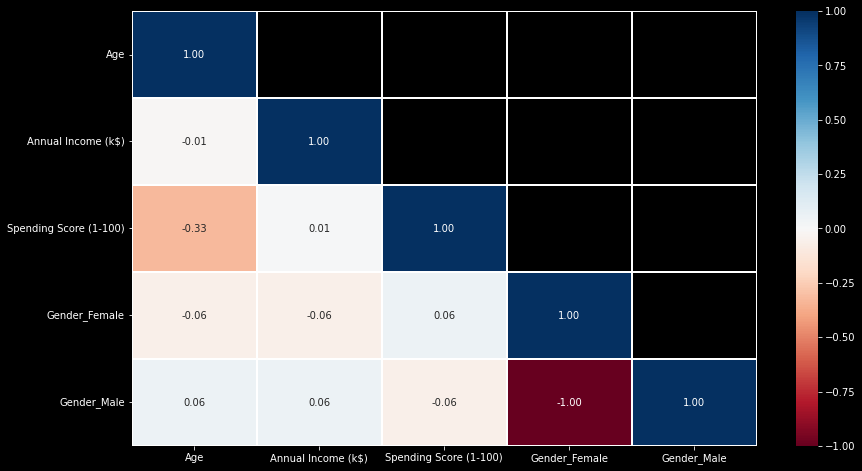

In [22]:
# Compute the correlation matrix
matrix = data_normalized.drop(columns=["CustomerID"]).corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(14, 8))

# set dark background for figure
plt.style.use("dark_background")

# Generate a mask for the lower triangle
mask = np.triu(matrix, 1)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(matrix, mask = mask, cmap = "RdBu", annot = True, 
            fmt = ".2f", linewidths = 0.5, vmin = -1, vmax = 1, center = 0);

In [23]:
# correlation scatterplot
fig = px.scatter(data_normalized, x="Age", y="Spending Score (1-100)")
fig.update_layout(
        title_text = "Correlation between age and spending score",
        template = 'plotly_dark',
        width = 700, 
        height = 500
)
fig.show()

We do not see a lot of correlation in most cases except for age and spending score, where we can find some decent correlation. At the same time Gender_Male and Gender_Female do not seem to be contributing much towards understanding the importance of datset, so we can drop it.



> Now that we determined the importance of some of our features, we need not perform normalization as the data is already standardized if we disregard Gender.



In [24]:
data_final = data.drop(columns=["Gender"])
data_final.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,2,21,15,81
2,3,20,16,6
3,4,23,16,77
4,5,31,17,40


### Principal Component Analysis (PCA)

Let us now perform PCA for dimensionality reduction

In [26]:
# fit the data
pca = PCA().fit(data_final.drop(columns=["CustomerID"]))

# plot explained variance
y = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(5)

fig = go.Figure(data=go.Scatter(x = x, y = y))
fig.update_layout(
        title_text = "Explained Variance by Components",
        xaxis_title_text = "Number of components",
        yaxis_title_text = "Cumulative explained variance", 
        template = 'plotly_dark',
        width = 700, 
        height = 500
)
fig.show()

Now usually we select the number of features that retain the maximum covariance (i.e around 80 - 90%), however, given the size and nature of our dataset, it is possible for us to make use of 2 principal components and retain all information.

In [27]:
# fit the data with 2 components
pca = PCA(n_components=2).fit(data_final.drop(columns=["CustomerID"]))

# perform tranformation
data_pca = pca.transform(data_final.drop(columns=["CustomerID"]))

# add column names
data_pca = pd.DataFrame(data_pca, columns = ['PC1','PC2'])
data_pca.head()

,PC1,PC2
0,-31.870508,-33.001425
1,0.763397,-56.843865
2,-57.408726,-13.122936
3,-2.169896,-53.477905
4,-32.174920,-30.387005


In [28]:
# visualize the Principal Components
fig = px.scatter(data_pca, x="PC2", y="PC1")
fig.update_layout(
        title_text = "Principal Components",
        template = 'plotly_dark',
        width = 700, 
        height = 500
)
fig.show()

### K-Means

**Elbow Method**

Number of clusters we need for a dataset cannot be random. A good way to find the ideal number of K clusters is by using WCSS (Within-Cluster-Sum-of-Squares). WCSS is the sum of squared distance between every data point and their respective centroids in a cluster(also called intertia).

In [32]:
wcss = []
for i in range(1, 11):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
  kmeans_pca.fit(data_pca)
  wcss.append(kmeans_pca.inertia_)

We then plot the WCSS against K ranging from 1-10 to get an Elbow plot

In [33]:
y = wcss
x = np.arange(11)

fig = go.Figure(data=go.Scatter(x = x, y = y))
fig.update_layout(
        title_text = "K-Means with PCA Clustering",
        xaxis_title_text = "Number of Clusters",
        yaxis_title_text = "WCSS", 
        template = 'plotly_dark',
        width = 700, 
        height = 500
)
fig.show()

Here it seems like 5 would be an optimal cluster count, however, we can use KneeLocator to solidify our pick

In [34]:
k_val = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
k_val.elbow

5

Using KneeLocator we determined that the optimal number of clusters would indeed be 5. Let us now use the optimal cluster count to finalize our K-Means model

In [35]:
# finalized K-Means model
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)

# fit our data to the finalized model
kmeans_pca.fit(data_pca)

KMeans(n_clusters=5, random_state=0)

In [36]:
# combine our new findings with original data
df_cluster = pd.concat([data, data_pca], axis=1)

# add K-Means cluster column
df_cluster['K-Means PCA'] = kmeans_pca.labels_

df_cluster.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),PC1,PC2,K-Means PCA
0,1,Male,19,15,39,-31.870508,-33.001425,3
1,2,Male,21,15,81,0.763397,-56.843865,4
2,3,Female,20,16,6,-57.408726,-13.122936,3
3,4,Female,23,16,77,-2.169896,-53.477905,4
4,5,Female,31,17,40,-32.174920,-30.387005,3


In [37]:
# map K-Means cluster numbers to string values
df_cluster['Cluster'] = df_cluster['K-Means PCA'].map({ 0: 'Cluster_1',
                                                        1: 'Cluster_2',
                                                        2: 'Cluster_3',
                                                        3: 'Cluster_4',
                                                        4: 'Cluster_5' })

df_cluster.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),PC1,PC2,K-Means PCA,Cluster
0,1,Male,19,15,39,-31.870508,-33.001425,3,Cluster_4
1,2,Male,21,15,81,0.763397,-56.843865,4,Cluster_5
2,3,Female,20,16,6,-57.408726,-13.122936,3,Cluster_4
3,4,Female,23,16,77,-2.169896,-53.477905,4,Cluster_5
4,5,Female,31,17,40,-32.174920,-30.387005,3,Cluster_4


Let us now visualize our K-Means clusters

In [38]:
fig = px.scatter(df_cluster, x="PC2", y="PC1", color="Cluster", hover_data=['CustomerID'])

fig.update_layout(
        title_text = "K-Means clusters",
        template = 'plotly_dark',
        width = 700, 
        height = 500
)
fig.show()